# Recommendation System Project
##### [1. Word Cloud Generation with "지원동기"](#1.-Word-Cloud-Generation)
##### [2. Topic Modeling to extract values](#2.-Topic-Modeling)
##### [3. FFM Prediction](#3.-FFM)

## 1. Word Cloud Generation

page_1_to_10.csv's valid motivs: 75 out of 96
page_11_to_22.csv's valid motivs: 55 out of 111
page_23_to_100.csv's valid motivs: 647 out of 780
page_101_to_200.csv's valid motivs: 869 out of 1000
page_201_to_300.csv's valid motivs: 501 out of 1000
page_301_to_376.csv's valid motivs: 4 out of 755
total valid reasons: 2151


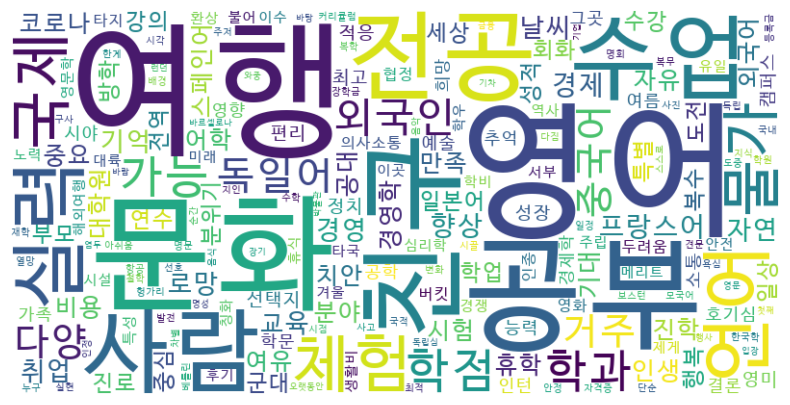

In [8]:
from extract_helper import *
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from konlpy.tag import Mecab
import os

path_to_files = "data_set"
files_to_process = ["page_1_to_10.csv", "page_11_to_22.csv", "page_23_to_100.csv", "page_101_to_200.csv", "page_201_to_300.csv", "page_301_to_376.csv"]

# 불용어 처리
stopwords = set()
with open("stopwords.txt", 'r', encoding='utf-8') as file:
    for line in file:
        words = line.split()  # 기본적으로 공백을 기준으로 split
        stopwords.update(words)  # set에 words 추가 (중복 제거)

# 각 파일에서 '지원 동기'에 해당하는 부분 parse
mecab = Mecab()  # mecab 형태소 분석기 생성
cleaned_text = ""
total_motivs = pd.Series(dtype=str)
for file_name in files_to_process:
    file_path = os.path.join(path_to_files, file_name)
    df = pd.read_csv(file_path)
    
    # csv 파일 내용 parse
    df['Selected Content'] = df.apply(select_content, axis=1)
    df['Processed Content'] = df.apply(process_content, axis=1)
    tot_len = len(df['Processed Content'])
    motivs = df['Processed Content'].dropna() # NAN 제거
    motivs = motivs[motivs.str.strip() != ""]  # 빈 문자열 제거
    
    print(f"{file_name}'s valid motivs: {len(motivs)} out of {tot_len}")
    total_motivs = pd.concat([total_motivs, motivs])

    # 텍스트 전처리
    text = ' '.join(motivs)  # 모든 텍스트를 결합
    nouns = mecab.nouns(text)  # 명사만 추출
    nouns = [word for word in nouns if len(word) > 1] # 한글자 삭제

    # 명사 리스트를 하나의 문자열로 변환
    cleaned_text += ' '.join(nouns)

print(f"total valid reasons: {len(total_motivs)}")

# WordCloud 객체 생성
cleaned_text = cleaned_text.split()
cleaned_text_cnt = Counter(cleaned_text)
min_freq = 10
cleaned_text_flt = {word: count for word, count in cleaned_text_cnt.items() if count >= min_freq and word not in stopwords}

font_path = "/Users/gayeonlee/Library/Fonts/D2Coding-Ver1.3.2-20180524.ttc"
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path, stopwords=stopwords).generate_from_frequencies(cleaned_text_flt)

# 워드 클라우드 표시
plt.figure(figsize=(10, 5))
plt.rc('font', family='AppleGothic')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 제거
plt.show()



## 2. Topic Modeling

Try find the "optimal" number of topics

Number of Topics: 2, Perplexity: 361.8960444681771
Number of Topics: 3, Perplexity: 373.5799137545868
Number of Topics: 4, Perplexity: 385.6359153137505
Number of Topics: 5, Perplexity: 393.4091760737158
Number of Topics: 6, Perplexity: 401.3008414449158
Number of Topics: 7, Perplexity: 408.35464290099685
Number of Topics: 8, Perplexity: 416.5197749339754
Number of Topics: 9, Perplexity: 413.8184483823854
Number of Topics: 10, Perplexity: 418.10980350084
Number of Topics: 11, Perplexity: 427.79097144106294
Number of Topics: 12, Perplexity: 424.3859992629287
Number of Topics: 13, Perplexity: 435.0095687196273
Number of Topics: 14, Perplexity: 438.1523278037292
Number of Topics: 15, Perplexity: 439.3882527223234
Number of Topics: 16, Perplexity: 438.5215336261841
Number of Topics: 17, Perplexity: 445.9503409294008
Number of Topics: 18, Perplexity: 445.6029080730815
Number of Topics: 19, Perplexity: 452.3978315954409
Number of Topics: 20, Perplexity: 456.8857640705183
Number of Topics: 21

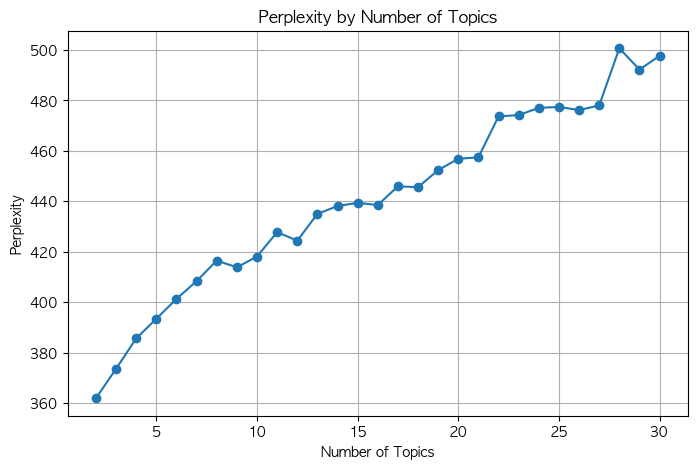

In [13]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# total_motivs 인덱스 재설정
total_motivs = total_motivs.reset_index(drop=True)

# 불용어 처리 및 전처리
total_motivs_filtered = total_motivs.apply(lambda x: preprocess_text(x, stopwords, mecab))

# 문서-단어 행렬 생성
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(total_motivs_filtered)

# 토픽 수별 Perplexity 계산
max_topics = 30
perplexities = []

for num_topics in range(2, max_topics + 1):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    perplexity = lda.perplexity(X)
    perplexities.append(perplexity)
    print(f"Number of Topics: {num_topics}, Perplexity: {perplexity}")

# Perplexity 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_topics + 1), perplexities, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity by Number of Topics")
plt.grid()
plt.show()

In [ ]:
import pyLDAvis

# 위에 결과에서 '최적'의 토픽 수 선정
optimal_topic_number = 29

# LDA 모델 학습
num_topics = optimal_topic_number  # 주제 수
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# 주제별 상위 단어 출력
terms = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    print(f"\n주제 {idx + 1}:")
    print([terms[i] for i in topic.argsort()[:-11:-1]])

# 문서별 주제 분포 출력
doc_topics = lda.transform(X)
doc_topic_df = pd.DataFrame(doc_topics, columns=[f"주제 {i + 1}" for i in range(num_topics)])

# TODO: 데이터에 value 항목 추가

# 문서-단어 행렬과 LDA 모델 결과를 시각화에 맞게 변환
lda_vis_data = pyLDAvis.prepare(
    topic_term_dists=lda.components_,          # LDA 주제-단어 분포
    doc_topic_dists=lda.transform(X),         # 문서-주제 분포
    doc_lengths=X.sum(axis=1).A1,             # 각 문서의 단어 수
    vocab=vectorizer.get_feature_names_out(), # 단어 목록
    term_frequency=X.sum(axis=0).A1          # 전체 단어 빈도
)

# 시각화 출력
pyLDAvis.display(lda_vis_data)
pyLDAvis.save_html(lda_vis_data, f'lda_visualization/lda_visualization_{optimal_topic_number}.html')


주제 1:
['여행', '만족', '환상', '거주', '공부', '친구', '가족', '휴학', '금융', '선택지']

주제 2:
['캠퍼스', '영어', '수업', '날씨', '캘리포니아', '친구', '국제', '실력', '여행', '남부']

주제 3:
['공대', '여행', '사람', '영어', '전공', '문화', '공부', '비용', '대륙', '주저']

주제 4:
['학점', '어학', '연수', '공부', '전공', '수업', '박물관', '여행', '어학연수', '유일']

주제 5:
['문화', '수업', '전공', '공부', '분야', '여행', '영어', '심리학', '학업', '강의']

주제 6:
['국제', '공부', '문화', '전공', '교육', '영어', '공학', '경영학', '컴퓨터', '사람']

주제 7:
['친구', '사람', '후기', '국제', '실현', '도전', '영어', '새내기', '공부', '대외']

주제 8:
['여행', '공부', '물가', '문화', '공대', '철학', '코로나', '학과', '전공', '경제']

주제 9:
['여행', '영어', '공부', '친구', '성적', '경제', '체험', '수업', '만하임', '학점']

주제 10:
['군대', '전역', '문화', '친구', '특별', '복무', '사람', '행복', '복학', '해외여행']

주제 11:
['여행', '추억', '치안', '연장', '시애틀', '공부', '혜택', '친구', '물가', '안전']

주제 12:
['영어', '공부', '시험', '외국어', '자연', '진학', '타국', '사람', '날씨', '능력']

주제 13:
['문화', '휴식', '반복', '휴학', '프랑스어', '역사', '다양', '기존', '다짐', '학문']

주제 14:
['전공', '공부', '학과', '문화', '정치', '프랑스어', '교육', '가능', '거주', '국제']

주제 15:
['영어', '실력', 